In [1]:
import tensorflow as tf
import os
from os import getcwd

In [2]:
path_inception = f"{getcwd()}/Models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# importing the inception_v3 from tensorflow
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Creating an instrance of inception_v3 model from the local pretrained weights.
local_weights_file = path_inception

pretrained_model = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights=None) 
pretrained_model.load_weights(local_weights_file)

# making all layers in pretrained model non-trainable
for layer in pretrained_model.layers:
    layer.trainable = False

# Summary of the model 
print(pretrained_model.summary())

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [3]:
last_layer = pretrained_model.get_layer('mixed8')
print('Shape of the output of last layer: ', last_layer.output_shape)
last_output = last_layer.output

Shape of the output of last layer:  (None, 3, 3, 1280)


In [4]:
# Flattening the output of the last layer named last_output
x = tf.keras.layers.Flatten()(last_output)
# Adding 3 fully connected layers along with dropout regularization
x = tf.keras.layers.Dense(1024, activation='relu')(x) 
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(724, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(pretrained_model.input, x) 

model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = 'Datasets/cats-v-dogs/training'
validation_dir = 'Datasets/cats-v-dogs/testing'

train_dir_cats = os.path.join(train_dir, 'cats')
validation_dir_cats = os.path.join(validation_dir, 'cats')
train_dir_dogs = os.path.join(train_dir, 'dogs')
validation_dir_dogs = os.path.join(validation_dir, 'dogs')

train_cats_fnames = os.listdir(train_dir_cats)
validation_cats_fnames = os.listdir(validation_dir_cats)
train_dogs_fnames = os.listdir(train_dir_dogs)
validation_dogs_fnames = os.listdir(validation_dir_dogs)

print(len(train_cats_fnames))
print(len(train_dogs_fnames))
print(len(validation_cats_fnames))
print(len(validation_dogs_fnames))

11250
11250
1250
1250


In [6]:
train_datagen = ImageDataGenerator(rescale=1./255., 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255.)

# Flow training images in batches of 100 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(150, 150), 
                                                    batch_size=100, 
                                                    class_mode='binary')

# Flow validation images in batches of 100 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(validation_dir, 
                                                              target_size=(150, 150),
                                                              batch_size=100, 
                                                              class_mode='binary')

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [7]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9:
            print('\nDesired accuracy of 90% has been reached, therefore cancelling training!!')
            self.model.stop_training=True

callbacks = myCallback()

In [8]:
history = model.fit(train_generator, epochs=15, validation_data=validation_generator, callbacks=[callbacks])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 225 steps, validate for 25 steps
Epoch 1/15
224/225 [============================>.] - ETA: 0s - loss: 0.3486 - accuracy: 0.8465

/home/inferno/.conda/envs/DeepLearning/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/inferno/.conda/envs/DeepLearning/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/inferno/.conda/envs/DeepLearning/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/inferno/.conda/envs/DeepLearning/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/inferno/.conda/envs/DeepL

225/225 [==============================] - 186s 828ms/step - loss: 0.3484 - accuracy: 0.8468 - val_loss: 0.1038 - val_accuracy: 0.9664
Epoch 2/15
225/225 [==============================] - 181s 804ms/step - loss: 0.2494 - accuracy: 0.8915 - val_loss: 0.1260 - val_accuracy: 0.9592
Epoch 3/15
225/225 [==============================] - 180s 801ms/step - loss: 0.2411 - accuracy: 0.8958 - val_loss: 0.0966 - val_accuracy: 0.9688
Epoch 4/15
224/225 [============================>.] - ETA: 0s - loss: 0.2321 - accuracy: 0.9001
Desired accuracy of 90% has been reached, therefore cancelling training!!
225/225 [==============================] - 180s 798ms/step - loss: 0.2320 - accuracy: 0.9001 - val_loss: 0.2161 - val_accuracy: 0.9416


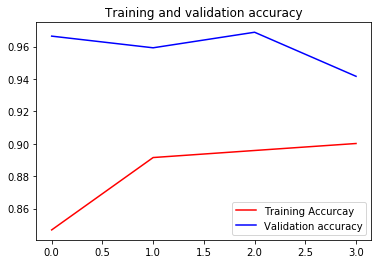

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accurcay')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.xlabel = 'Epochs'
plt.ylabel = 'Accuracy'
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()